# Lab 08 RNN 

## Goal 

In this lab section, you will need to do:
1. Load the dataset with pandas library.
2. Apply selection on the dataset and filter the feature you want.
3. Apply one-hot encoding to the label.
4. Build a LSTM model with the data you have, and choose a suitable activation function and loss function.
5. Evaluate the performance of model by computing the AUC and visualize the ROC curve.

## Introduction

A jet object may physically contains several constituents. These constituents can be treat as a sequence and regard as a data can be train by RNN. You have already tried to train a simple model in in-class quiz section. Now, you need to do somthing a little bit complicate than in-class quiz. 

For a jet contains with less than 5 constituents, we may negelect this jet. 

We used **5** constituents to train the model in in-class quiz. Now you will need to use **15** constituents to train the model.


In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from sklearn.utils import shuffle
import time
%config InlineBackend. figure_format = 'retina'

# Import TensorFlow and scikit-learn
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow Version is 2.4.1
Keras Version is 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 707984475228638766
]
/kaggle/input/phys591000-week08/Data_LSTM_10000.csv
/kaggle/input/phys591000-week08/Data_LSTM_Large.csv


## Part 1

In this part, you need to load the data from csv file locate in `/kaggle/input/phys591000-week08/Data_LSTM_Large.csv`.
This is a dataset with same stucture but different number of jet compare to the dataset you used in in-class quiz.

**Please show how many wz/quark process exist in this dataset.**

In [2]:
#################################################################################################################################
# Code for part 1
data = pd.read_csv("/kaggle/input/phys591000-week08/Data_LSTM_Large.csv")
df = pd.DataFrame(data)
wz_label = df[df["label"]==0]
quark_label = df[df["label"]==1]

#N_jet = len(np.unique(df['jet_index']))
N_wz_jet = len(np.unique(wz_label['jet_index']))
N_quark_jet = len(np.unique(quark_label['jet_index']))

#print(N_jet)
print("number of wz processes:", N_wz_jet)
print("number of quark processes:", N_quark_jet)


#################################################################################################################################

number of wz processes: 35000
number of quark processes: 35000


In [3]:
print(df)

                   pt       eta      phi             e   rel_eta   rel_phi  \
0        2.719160e+00 -0.180671 -2.01835  2.767182e+00  0.006018 -0.168892   
1        1.491620e+00 -0.120613 -1.97244  1.508951e+00  0.066076 -0.122982   
2        1.867510e+00 -0.204967 -1.72660  1.911977e+00 -0.018278  0.122858   
3        2.474740e+00 -0.307059 -1.82164  2.595837e+00 -0.120370  0.027818   
4        9.438140e-01 -0.112454 -1.88135  9.593314e-01  0.074235 -0.031892   
...               ...       ...      ...           ...       ...       ...   
2455887  5.323430e+00  1.153980 -2.15335  9.280164e+00  0.162644 -0.178295   
2455888  1.776760e+01  1.147940 -2.15671  3.081805e+01  0.156604 -0.181655   
2455889  7.103650e-01  1.360780 -1.87156  1.482189e+00  0.369444  0.103495   
2455890  1.718780e+00  1.292880 -2.05207  3.369574e+00  0.301544 -0.077015   
2455891  2.561310e-12  1.511660 -1.52646  6.089252e-12  0.520324  0.448595   

         jet_index process  label  
0                0   quark 

## Part 2 

Apply following selection to the dataset and store the **top-15** constituents' `pt`, `rel_eta`, `rel_phi`, and `e` of the accepted jet to numpy array.  
Be sure that you apply on both process and combine the result together as you did in in-class quiz.

== **Selection** ==  
The jet should at least constains more than **10** constituents.


== **zero paddind** ==  
Although we select the jet with more than **10** constituents. But we request a array with **top-15** constituents.  
It means the selected jet may not have 15 constituents. So you need to do a **zero padding** in order to make the data have the same shape.  
The zero padding can be done by initiate a array with `numpy.zeros` function.  

Once you finished the selection, you may need to prepare the label of the data.
We will label the quark process as **0** and wz process **1**.  
Using one-hot encoding as the encoder, please construct a array with one-hot encoded label.

Hint: The array after selection will be (N_accepted_jet, 15, 4)  
Hint: The target array with one-hot encoding will be (N_accepted_jet, 2)  

In [4]:
#################################################################################################################################
# Code for part 2
train_array = []

df = pd.DataFrame(data)
WZ_jet = df.loc[df["label"]==1]
quark_jet = df.loc[df["label"]==0]

wz_array = []
quark_array = []
for i in range(35000):
    if len(WZ_jet[WZ_jet["jet_index"]==i]) >= 15:
        wz_tmp = WZ_jet[WZ_jet["jet_index"]==i]
        wz_array.append(wz_tmp[["pt","eta","phi","e"]][0:15].values)
    elif len(WZ_jet[WZ_jet["jet_index"]==i]) > 10 and len(WZ_jet[WZ_jet["jet_index"]==i]) < 15:
        wz_tmp = WZ_jet[WZ_jet["jet_index"]==i].filter(["pt","eta","phi","e"]).values
        wz_tmp = np.concatenate((wz_tmp,np.zeros((15 - len(WZ_jet[WZ_jet["jet_index"]==i]),4))),axis=0)
        wz_array.append(wz_tmp)
    else:
        pass

        
        
for i in range(35000):
    if len(quark_jet[quark_jet["jet_index"]==i]) >= 15:
        quark_tmp = quark_jet[quark_jet["jet_index"]==i]
        quark_array.append(quark_tmp[["pt","eta","phi","e"]][0:15].values)
    elif len(quark_jet[quark_jet["jet_index"]==i]) > 10 and len(quark_jet[quark_jet["jet_index"]==i]) < 15:
        quark_tmp = quark_jet[quark_jet["jet_index"]==i].filter(["pt","eta","phi","e"]).values
        quark_tmp = np.concatenate((quark_tmp,np.zeros((15 - len(quark_jet[quark_jet["jet_index"]==i]),4))),axis=0)
        quark_array.append(quark_tmp)
    else:
        pass
wz_array = np.array(wz_array)
quark_array = np.array(quark_array)
train_array = np.concatenate((quark_array,wz_array),axis=0)
print(wz_array.shape)
print(quark_array.shape)
print("The shape of train array:", train_array.shape)

#print(wz_array[9478,:,:])

#################################################################################################################################

(34973, 15, 4)
(34878, 15, 4)
The shape of train array: (69851, 15, 4)


In [6]:
print(train_array)

[[[ 2.71916000e+00 -1.80671000e-01 -2.01835000e+00  2.76718230e+00]
  [ 1.49162000e+00 -1.20613000e-01 -1.97244000e+00  1.50895143e+00]
  [ 1.86751000e+00 -2.04967000e-01 -1.72660000e+00  1.91197690e+00]
  ...
  [ 2.14987000e+02 -1.92136000e-01 -1.85236000e+00  2.18967523e+02]
  [ 6.93230000e+01 -1.84948000e-01 -1.85600000e+00  7.05121446e+01]
  [ 1.08548000e+02 -1.81496000e-01 -1.84439000e+00  1.10341864e+02]]

 [[ 1.05818000e+01  2.48630000e-02 -6.49066000e-01  1.05859314e+01]
  [ 8.07765000e+00  1.16588000e-02 -6.39539000e-01  8.07932662e+00]
  [ 1.04162000e+01 -1.50407000e-02 -5.94902000e-01  1.04183131e+01]
  ...
  [ 2.10970000e+02  1.03889000e-02 -6.04851000e-01  2.10981428e+02]
  [ 8.78876000e+01  7.15499000e-03 -6.00390000e-01  8.78912362e+01]
  [ 9.70295000e+01  1.22059000e-02 -5.99285000e-01  9.70368219e+01]]

 [[ 2.01412000e+01 -1.24273000e+00  3.12786000e+00  3.78132052e+01]
  [ 6.63110000e+00 -1.25442000e+00 -3.10004000e+00  1.25701763e+01]
  [ 1.05156000e+00 -1.29330000e+

In [5]:
target_array = []
for i in range(train_array.shape[0]):
    if i < quark_array.shape[0]:
        target_array.append(0)
    elif i >= quark_array.shape[0]:
        target_array.append(1)
target_array = np.array(target_array)
print(target_array)

target_array = to_categorical(target_array)
print(target_array)
print("The shape of target array:", target_array.shape)

[0 0 0 ... 1 1 1]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
The shape of target array: (69851, 2)


## Part 3

Now, please construct a model with following structure.  
You may need to choose a suitable activation function and loss function in order to train the model properly.  
Please describe the reason of your choice in 3.1 and write down your code in 3.2

**Hint: Please do not try to apply the function before you answer 3.1, this may waste your time since we need to train with a larger epoch and larger dataset in this lab.**  
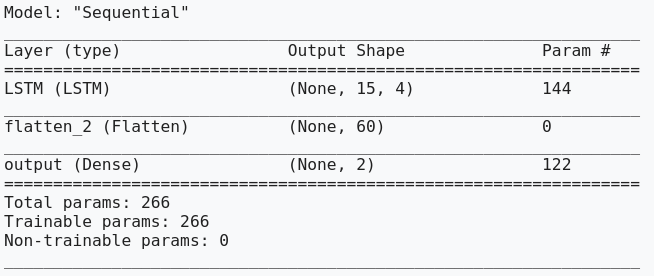


### Part 3.1

Your answer:


ReLu is less computationally expensive than tanh and sigmoid, so we apply ReLu in the LSTM layer to save the computation time.
Sigmoid usually used in output layer of a binary classification; therefore, we choose it to be the activation funciton in the output layer to train the model. 

In [7]:
#################################################################################################################################
# Code for part 3.2
input_shape = (15,4)
model = Sequential(name = 'Sequential')
model.add(LSTM(units = 4, activation = 'relu', return_sequences = True, input_shape = input_shape, name = "LSTM"))
model.add(Flatten(name = "flatten_2"))
model.add(Dense(units = 2, activation = 'sigmoid', name = "output"))

model_opt = keras.optimizers.Adam()

model.compile(#loss="categorical_crossentropy",
                   loss = "binary_crossentropy",
                   optimizer = model_opt,
                   metrics=["accuracy","mse"])

model.summary()


#################################################################################################################################

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 15, 4)             144       
_________________________________________________________________
flatten_2 (Flatten)          (None, 60)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 122       
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________


## Part 4 

Now, separate your data into two part, train dataset and test dataset.

You can decide the size of the test dataset.


In [8]:
#################################################################################################################################
# Code for part 4
X_train, X_test, Y_train, Y_test = train_test_split(
    train_array, target_array, test_size=0.10, random_state=42)

#################################################################################################################################

## Part 5

Train the model with your dataset.  
Set epoch to `500` and batch size to `64`.<br>
An arbitray validation split is fine.  

Epoch 1/500
885/885 [==============================] - 8s 8ms/step - loss: 0.7935 - accuracy: 0.5289 - mse: 0.2628 - val_loss: 0.6929 - val_accuracy: 0.5438 - val_mse: 0.2493
Epoch 2/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6916 - accuracy: 0.5384 - mse: 0.2489 - val_loss: 0.6892 - val_accuracy: 0.5341 - val_mse: 0.2479
Epoch 3/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6881 - accuracy: 0.5425 - mse: 0.2474 - val_loss: 0.6875 - val_accuracy: 0.5325 - val_mse: 0.2469
Epoch 4/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6844 - accuracy: 0.5631 - mse: 0.2455 - val_loss: 0.6791 - val_accuracy: 0.5928 - val_mse: 0.2420
Epoch 5/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6746 - accuracy: 0.5983 - mse: 0.2404 - val_loss: 0.6677 - val_accuracy: 0.6105 - val_mse: 0.2371
Epoch 6/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6654 - accuracy: 0.6062 - mse: 0.2362 - val_loss

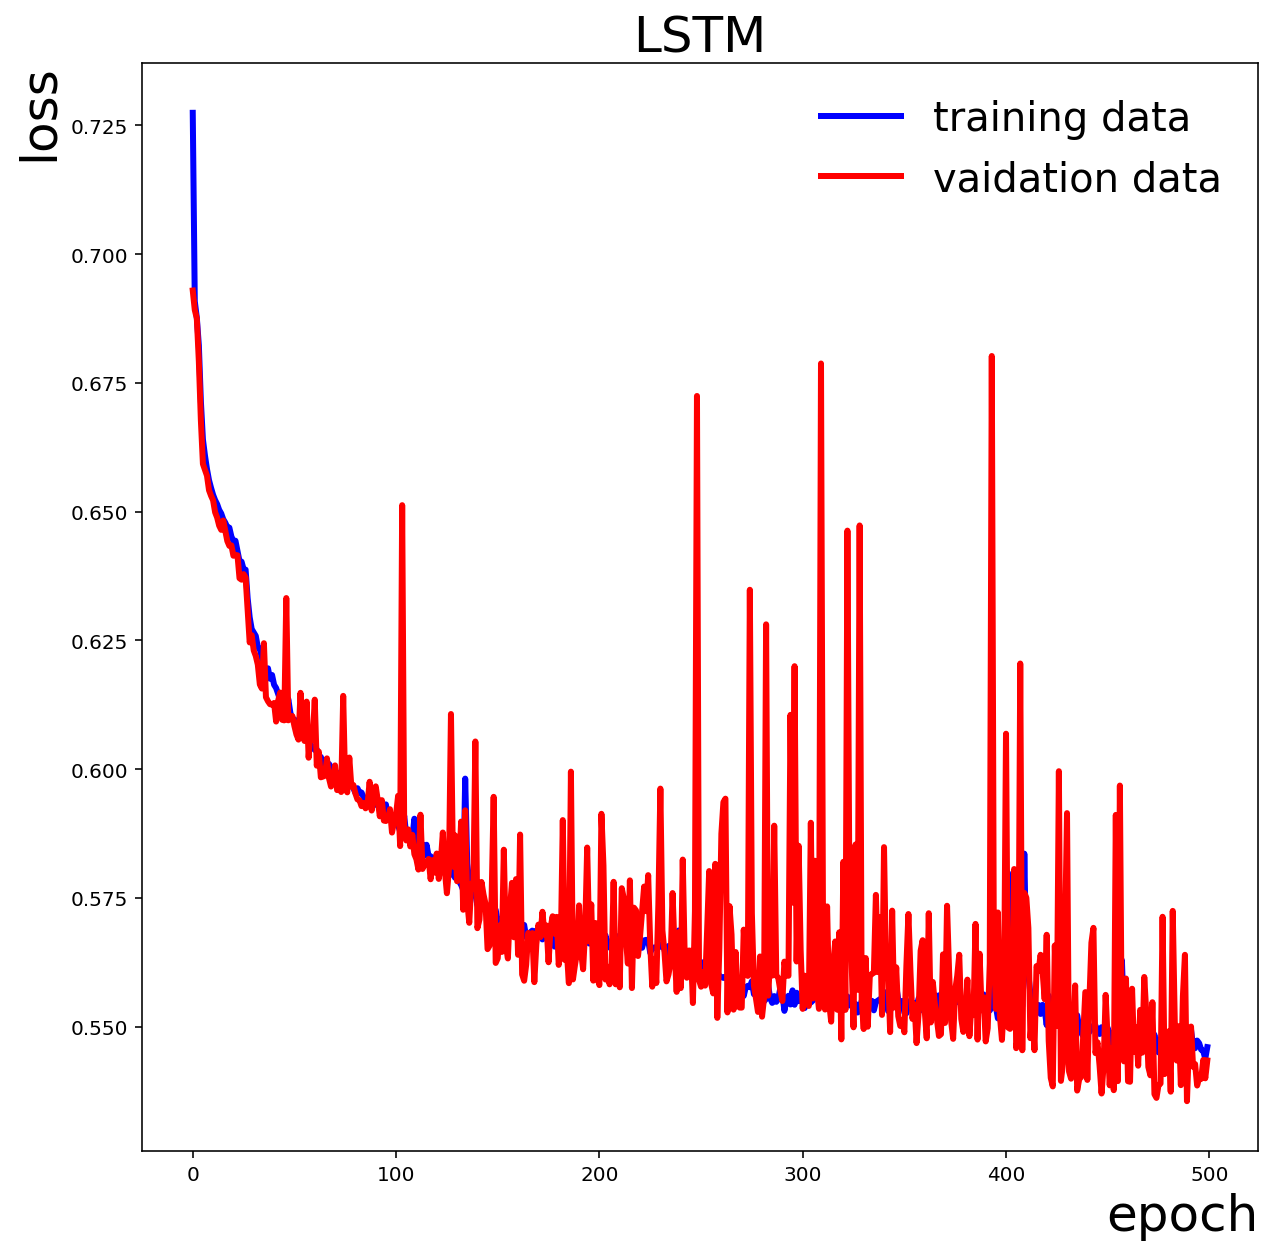

In [9]:
#################################################################################################################################
# Code for part 5
History_jet = model.fit( X_train, Y_train,
               validation_split= 0.1,
               batch_size=64,
               epochs=500,
               #shuffle = True,
               verbose=1
              )


fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.plot(History_jet.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History_jet.history["val_loss"], label='vaidation data',c='red',linewidth = 3)

plt.title("LSTM", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

#################################################################################################################################

## Part 6
Using the test dataset you obtained in part 3 to plot the ROC curve and compute AUC.

Test accuracy is 68.58001947402954


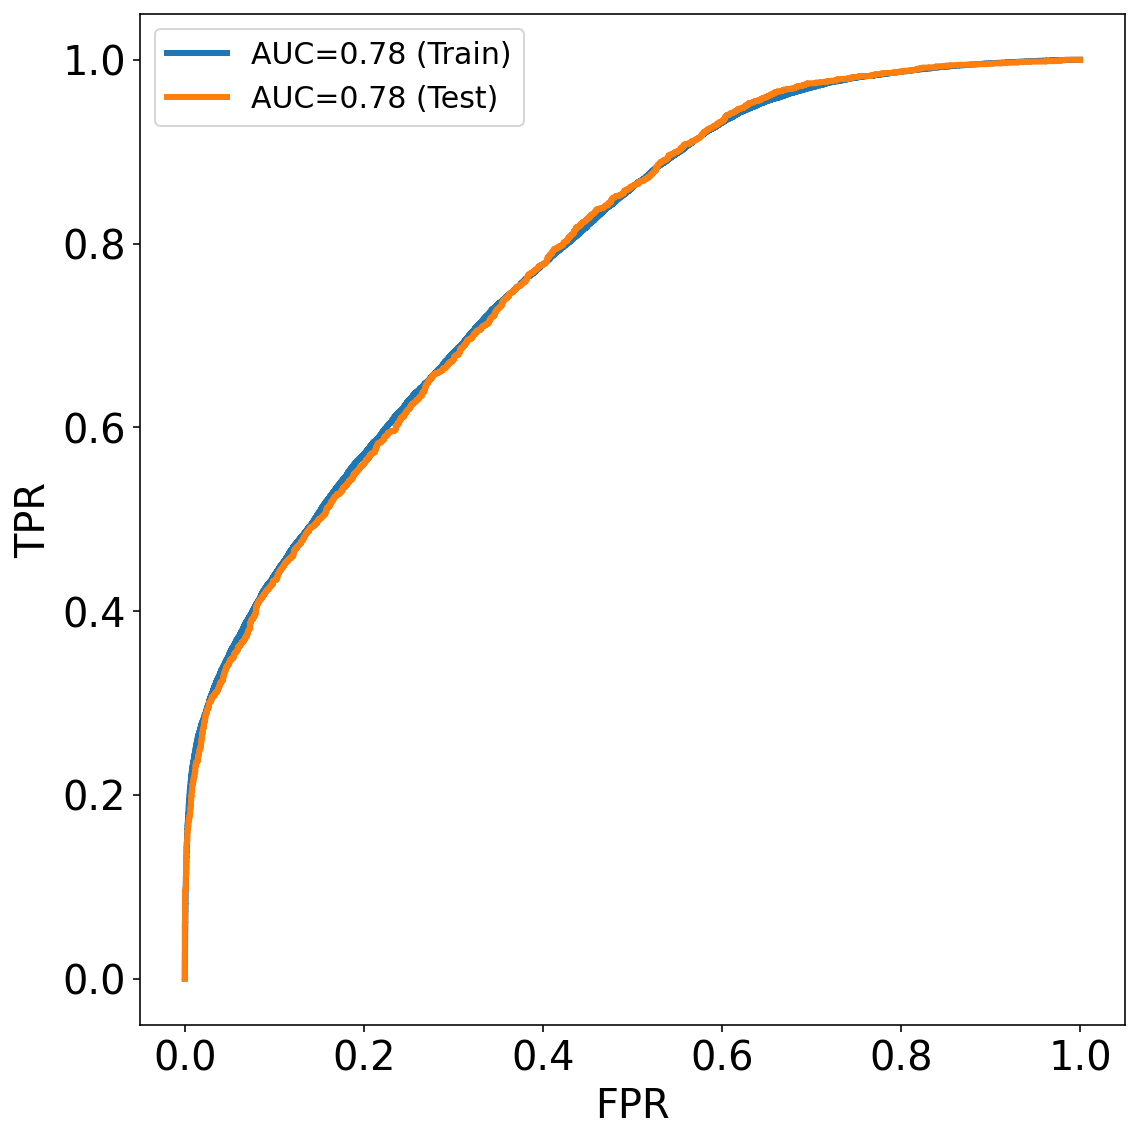

In [10]:
#################################################################################################################################
# Code for part 6
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

"""
Load Model
"""
#model.save("./model_RNN2.h5")
#Model_jet = load_model("./model_RNN2.h5")

"""
Make Prediction for Train and Test Data Set
"""
Y_train_prediction = model.predict(X_train)
Y_test_prediction = model.predict(X_test)

"""
Evaluate the model
"""
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test accuracy is {}".format(scores[1] * 100))


"""
Define axis for ROC
"""  
axis = 0
if axis == 0:
    Class = "W/Z jets"
    other = "Quark jets"
elif axis == 1:
    Class = "Quark jets"
    other = "W/Z jets"

"""
Calculate AUC
"""
auc_train = metrics.roc_auc_score(Y_train[:,axis],Y_train_prediction[:,axis])
auc_test = metrics.roc_auc_score(Y_test[:,axis],Y_test_prediction[:,axis])


"""
Calculate FPR and TPR
"""
FalsePositive_train, TruePositive_train, _ = metrics.roc_curve(Y_train[:,axis],Y_train_prediction[:,axis])
FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(Y_test[:,axis],Y_test_prediction[:,axis])


"""
Generate ROC figure
"""
fig, ax = plt.subplots(1,1, figsize=(8,8))


plt.plot(FalsePositive_train, TruePositive_train,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Train)'.format(auc_train))
plt.plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()




#################################################################################################################################

## Part 7 

Compare the differenct between the model in in-class quiz and lab section.
The discussion should at least contains:
1. Model structure
2. Hyper parameter
3. Activation/loss functions
4. Performance
5. The probable way to imporve the performance.

1.Compared with in-class, the model structure in lab contains an additional flatten layer with the 'return_sequences = True' in the first layer. The batch size and epoch in lab are 64 and 500, while those in in-class are 64 and 200, respectively. The change of the setting in return_sequences may be the most inflential differences. 

2.The loss function in lab and in-class both decreased very quickly at the beginning. Besides, the loss function of validation data in in-class increased as the epoch increase, but the loss function of training data decreased. However, in lab, the loss funciton of both validation and training data remain roughly constant after the quickly droping in the beginning of the epoches.But for the validation data in version 4, it has better performance, while it will oscillate after dropping quickly in this version.

3.The test accuracy in in-class is 53.9, while the one in lab is 68.58. Obviously, the performance in lab is better than in-class. The possible way to improve the performance is to increase the training data set and eliminate the data set with few constituents. Also, one can also try to use different types of maching learning architecture.

== **Your answer for part 7** ==

## Bonus 1

Please try to use different RNN structure(e.g. GRU) to train the model.
Describe why you choose it and compare its performace with the model you trained in Lab section.

In [28]:
#################################################################################################################################
# Code for Bonus 1
input_shape = (15,4)
modelGRU = Sequential(name = 'Sequential_GRU')
modelGRU.add(GRU(units = 4, activation = 'relu', return_sequences = True, input_shape = input_shape, name = "GRU"))
modelGRU.add(Flatten(name = "flatten_GRU"))
modelGRU.add(Dense(units = 2, activation = 'sigmoid', name = "output_GRU"))

model_opt = keras.optimizers.Adam()

modelGRU.compile(#loss="categorical_crossentropy",
                   loss = "binary_crossentropy",
                   optimizer = model_opt,
                   metrics=["accuracy","mse"])

modelGRU.summary()
#################################################################################################################################

Model: "Sequential_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 15, 4)             120       
_________________________________________________________________
flatten_GRU (Flatten)        (None, 60)                0         
_________________________________________________________________
output_GRU (Dense)           (None, 2)                 122       
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6342 - accuracy: 0.6239 - mse: 0.2228 - val_loss: 0.6282 - val_accuracy: 0.6391 - val_mse: 0.2198
Epoch 2/500
885/885 [==============================] - 7s 7ms/step - loss: 0.6326 - accuracy: 0.6276 - mse: 0.2220 - val_loss: 0.6316 - val_accuracy: 0.6353 - val_mse: 0.2213
Epoch 3/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6314 - accuracy: 0.6280 - mse: 0.2216 - val_loss: 0.6263 - val_accuracy: 0.6323 - val_mse: 0.2191
Epoch 4/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6303 - accuracy: 0.6272 - mse: 0.2211 - val_loss: 0.6242 - val_accuracy: 0.6351 - val_mse: 0.2182
Epoch 5/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6287 - accuracy: 0.6280 - mse: 0.2204 - val_loss: 0.6298 - val_accuracy: 0.6375 - val_mse: 0.2206
Epoch 6/500
885/885 [==============================] - 6s 7ms/step - loss: 0.6282 - accuracy: 0.6288 - mse: 0.2202 - val_loss

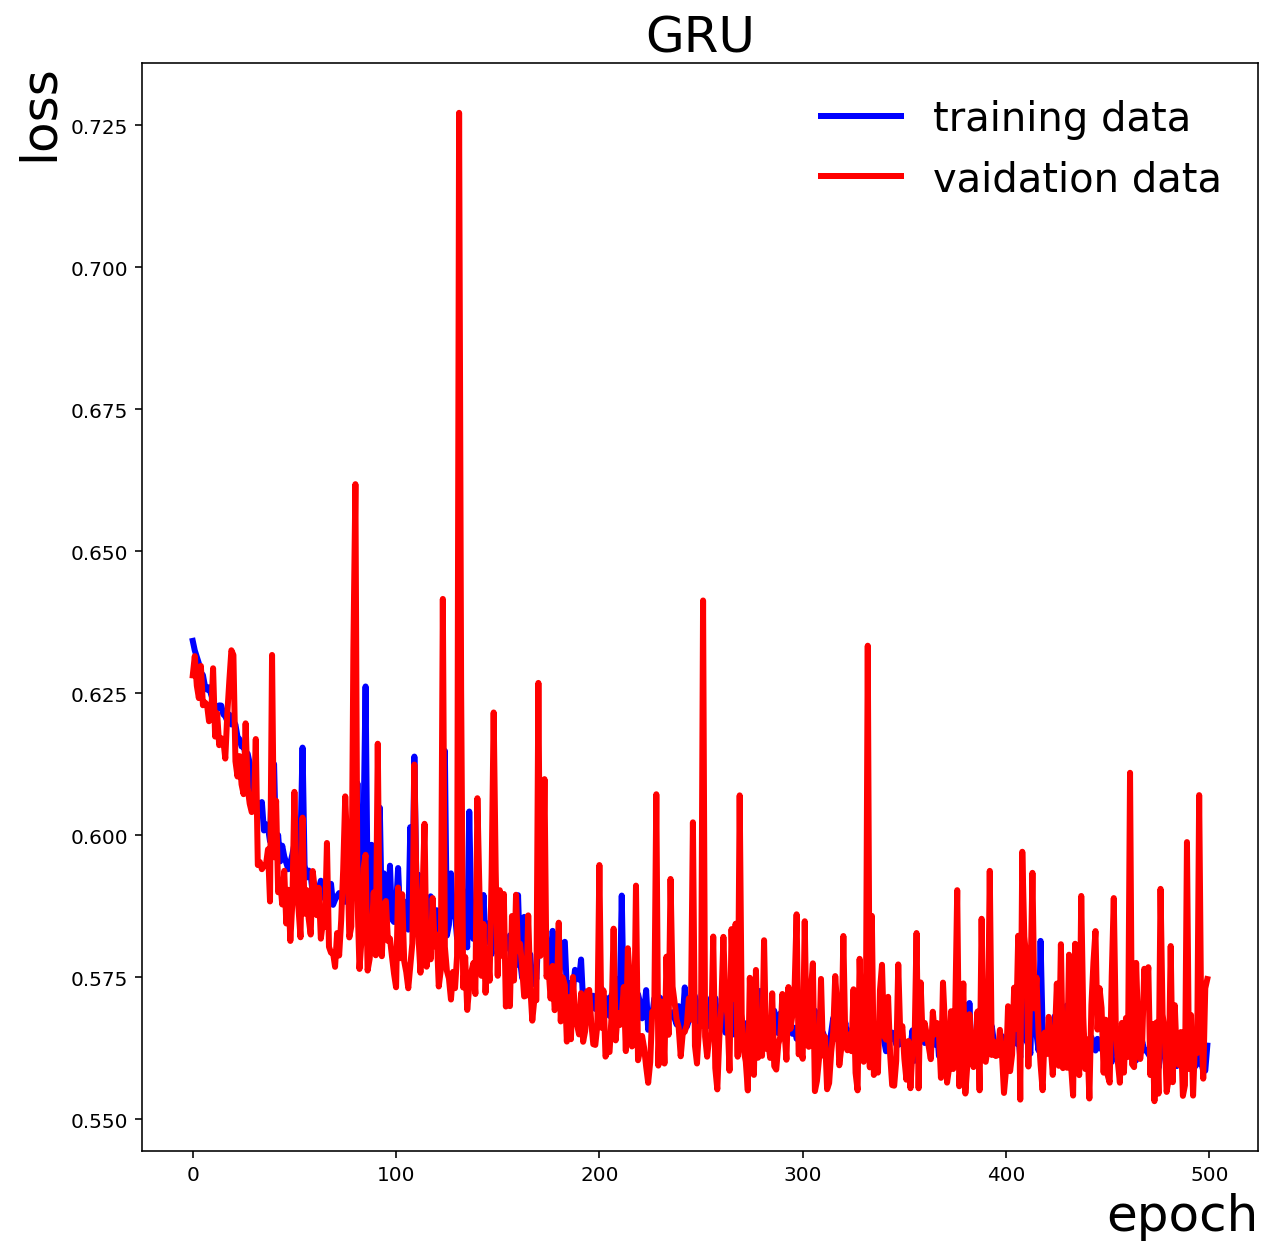

In [31]:
History_jet_GRU = modelGRU.fit( X_train, Y_train,
               validation_split= 0.1,
               batch_size=64,
               epochs=500,
               #shuffle = True,
               verbose=1
              )


fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.plot(History_jet_GRU.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History_jet_GRU.history["val_loss"], label='vaidation data',c='red',linewidth = 3)

plt.title("GRU", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

Test accuracy is 66.07500910758972


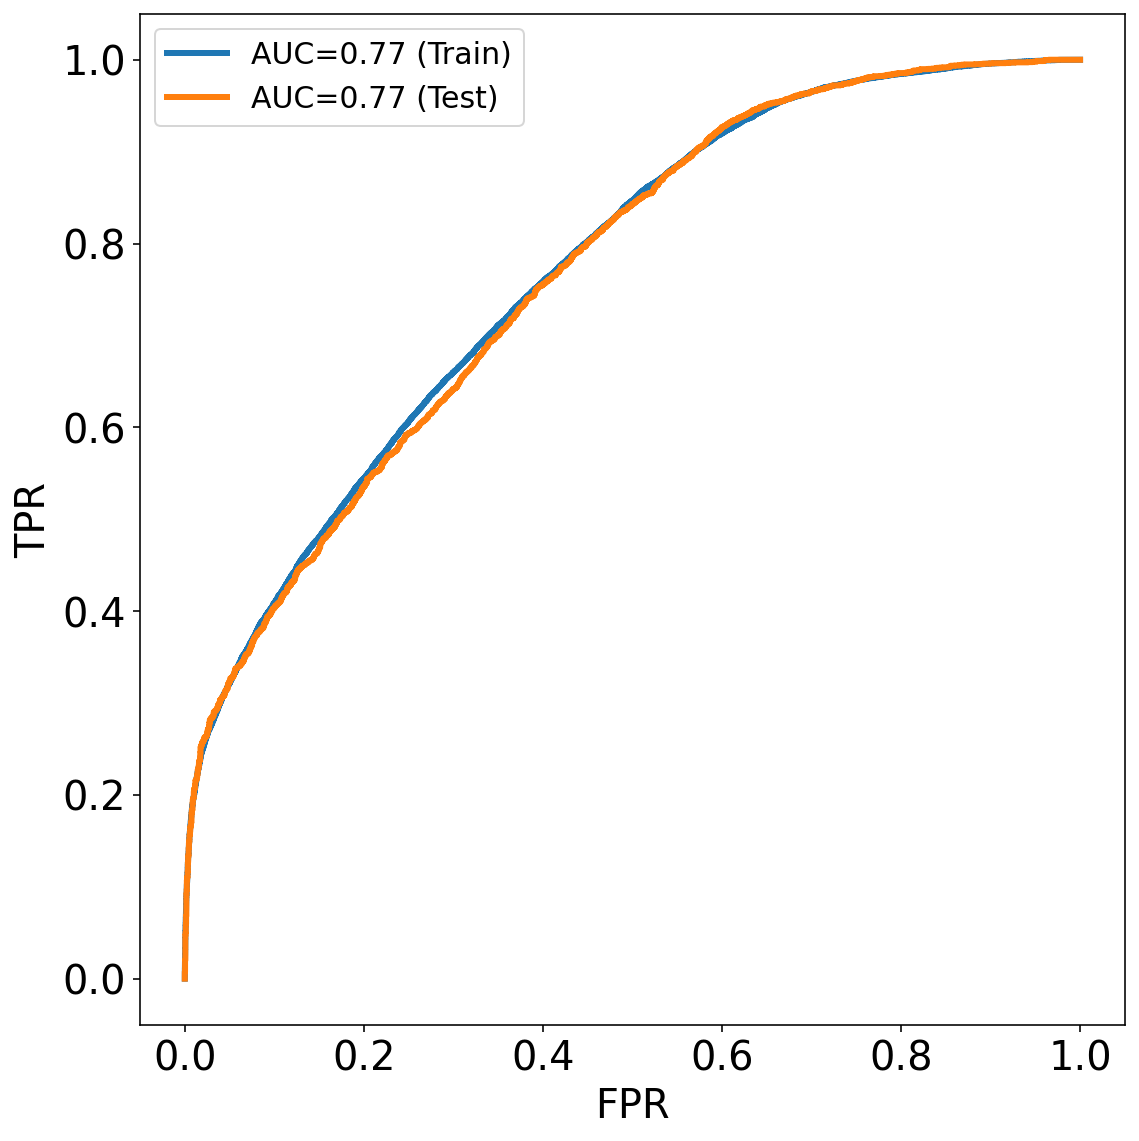

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

"""
Load Model
"""
#model.save("./model_RNN2.h5")
#Model_jet = load_model("./model_RNN2.h5")

"""
Make Prediction for Train and Test Data Set
"""
Y_train_prediction_GRU = modelGRU.predict(X_train)
Y_test_prediction_GRU = modelGRU.predict(X_test)

"""
Evaluate the model
"""
scores = modelGRU.evaluate(X_test, Y_test, verbose=0)
print("Test accuracy is {}".format(scores[1] * 100))


"""
Define axis for ROC
"""  
axis = 0
if axis == 0:
    Class = "W/Z jets"
    other = "Quark jets"
elif axis == 1:
    Class = "Quark jets"
    other = "W/Z jets"

"""
Calculate AUC
"""
auc_train = metrics.roc_auc_score(Y_train[:,axis],Y_train_prediction_GRU[:,axis])
auc_test = metrics.roc_auc_score(Y_test[:,axis],Y_test_prediction_GRU[:,axis])


"""
Calculate FPR and TPR
"""
FalsePositive_train, TruePositive_train, _ = metrics.roc_curve(Y_train[:,axis],Y_train_prediction_GRU[:,axis])
FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(Y_test[:,axis],Y_test_prediction_GRU[:,axis])


"""
Generate ROC figure
"""
fig, ax = plt.subplots(1,1, figsize=(8,8))


plt.plot(FalsePositive_train, TruePositive_train,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Train)'.format(auc_train))
plt.plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()


Compare them with accuracy and ROC curve, it seems that LSTM has better performance. However, GRU has fewer parameter and run fast. 

## Bonus 2 

Try to establish a model you built in part 3.2 in a alternative way, i.e. `Functional API`.
You can read the document provided by tensorflow and build a model using functional API by yourself.

Ref. https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [ ]:
#################################################################################################################################
# Code for Bonus 1

#################################################################################################################################